In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import numpy as np
import warnings
import os
from sklearn.metrics import roc_curve, roc_auc_score
from math import ceil

pd.set_option('display.max_colwidth', None)
tqdm.pandas()
warnings.filterwarnings("ignore", category=UserWarning)

In [61]:
individual_json_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-War-Combined/lightning_logs/version_3/checkpoints/converted/epoch=4-step=19375.test_results.json'
json_folder_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-War-Combined/lightning_logs/version_3/checkpoints/converted/'

In [62]:
labels = ['toxicity','severe_toxicity','obscene','threat','insult','identity_attack']

In [63]:
with open(individual_json_path) as f:
    results = json.load(f)

In [55]:
multi_epoch_data = {}

for filename in os.listdir(json_folder_path):
    if filename.endswith(".json"):
        epoch = int(filename.split('=')[1].split('-')[0])
        file_path = os.path.join(json_folder_path, filename)
        with open(file_path) as f:
            data = json.load(f)
            multi_epoch_data[epoch] = data

multi_epoch_data = dict(sorted(multi_epoch_data.items()))


# Graphs

In [3]:
def plot_histogram(target_scores, pred_scores):
    nrows = ceil((len(target_scores) + 1) / 3)
    height = 12 * nrows / 3
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(12, height))
    axs = axs.flatten()
    final_plot = len(target_scores)

    for i, (label, scores) in enumerate(target_scores.items()):
        axs[i].hist(scores, bins=50, alpha=0.5, color='r', range=(0, 1), label="Targets")
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Histogram for "{label}"')
        axs[i].set_yscale('log')
    
    for i, (label, scores) in enumerate(pred_scores.items()):
        axs[i].hist(scores, bins=50, alpha=0.5, range=(0, 1), label="Predictions")
        axs[i].legend()

    all_target_scores = [value for values in target_scores.values() for value in values]
    all_pred_scores = [value for values in pred_scores.values() for value in values]
    axs[final_plot].hist(all_target_scores, bins=50, alpha=0.5, color='r', range=(0, 1), label="Targets")
    axs[final_plot].hist(all_pred_scores, bins=50, alpha=0.5, range=(0, 1), label="Predictions")
    axs[final_plot].legend()
    axs[final_plot].set_xlabel('Value')
    axs[final_plot].set_ylabel('Frequency')
    axs[final_plot].set_title("Histogram for All Prompts")
    axs[final_plot].set_yscale('log')

    plt.tight_layout()
    plt.show()

In [27]:
def plot_roc_auc(target_scores, pred_scores):
    nrows = ceil((len(target_scores) + 1) / 3)
    height = 12 * nrows / 3
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(12, height))
    axs = axs.flatten()
    final_plot = len(target_scores)

    for i, (label, scores) in enumerate(target_scores.items()):
        target_score = scores
        pred_score = pred_scores[label]

        fpr, tpr, thresholds = roc_curve(target_score,  pred_score)
        auc = roc_auc_score(target_score, pred_score)
        axs[i].plot(fpr,tpr,label=f"AUC={auc:.4f}")
        axs[i].legend()
        axs[i].set_xlabel('True Positive Rate')
        axs[i].set_ylabel('False Positive Rate')
        axs[i].set_title(f'ROC-AUC for "{label}"')

    all_target_scores = [value for values in target_scores.values() for value in values]
    all_pred_scores = [value for values in pred_scores.values() for value in values]
    fpr, tpr, thresholds = roc_curve(all_target_scores,  all_pred_scores)
    auc = roc_auc_score(all_target_scores, all_pred_scores)
    axs[final_plot].plot(fpr,tpr,label=f"AUC={auc:.4f}")
    axs[final_plot].legend()
    axs[final_plot].set_xlabel('True Positive Rate')
    axs[final_plot].set_ylabel('False Positive Rate')
    axs[final_plot].set_title("ROC-AUC for All Labels")

    plt.tight_layout()
    plt.show()

In [48]:
def plot_score_graph(scores, x_label, title):
    f1_scores = [scores[e]['f1'] for e in scores]
    recall_scores = [scores[e]['recall'] for e in scores]
    precision_scores = [scores[e]['precision'] for e in scores]

    plt.plot(list(scores.keys()), f1_scores, label='F1')
    plt.plot(list(scores.keys()), recall_scores, label='Recall')
    plt.plot(list(scores.keys()), precision_scores, label='Precision')

    plt.xlabel(x_label)
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Histograms + ROC-AUC Graphs

## Jigsaw Data

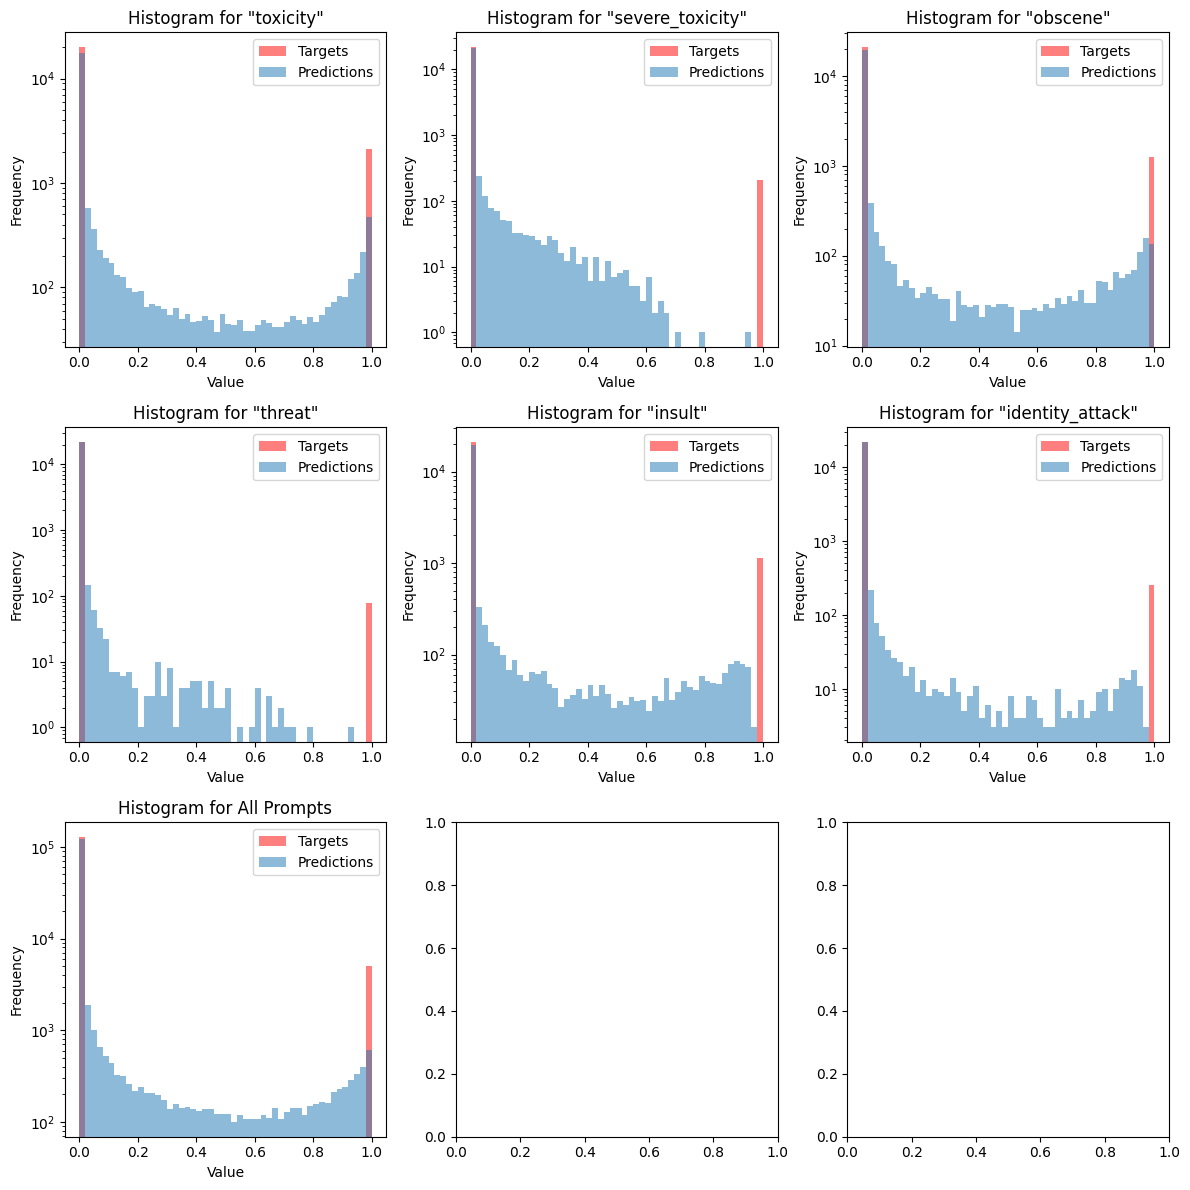

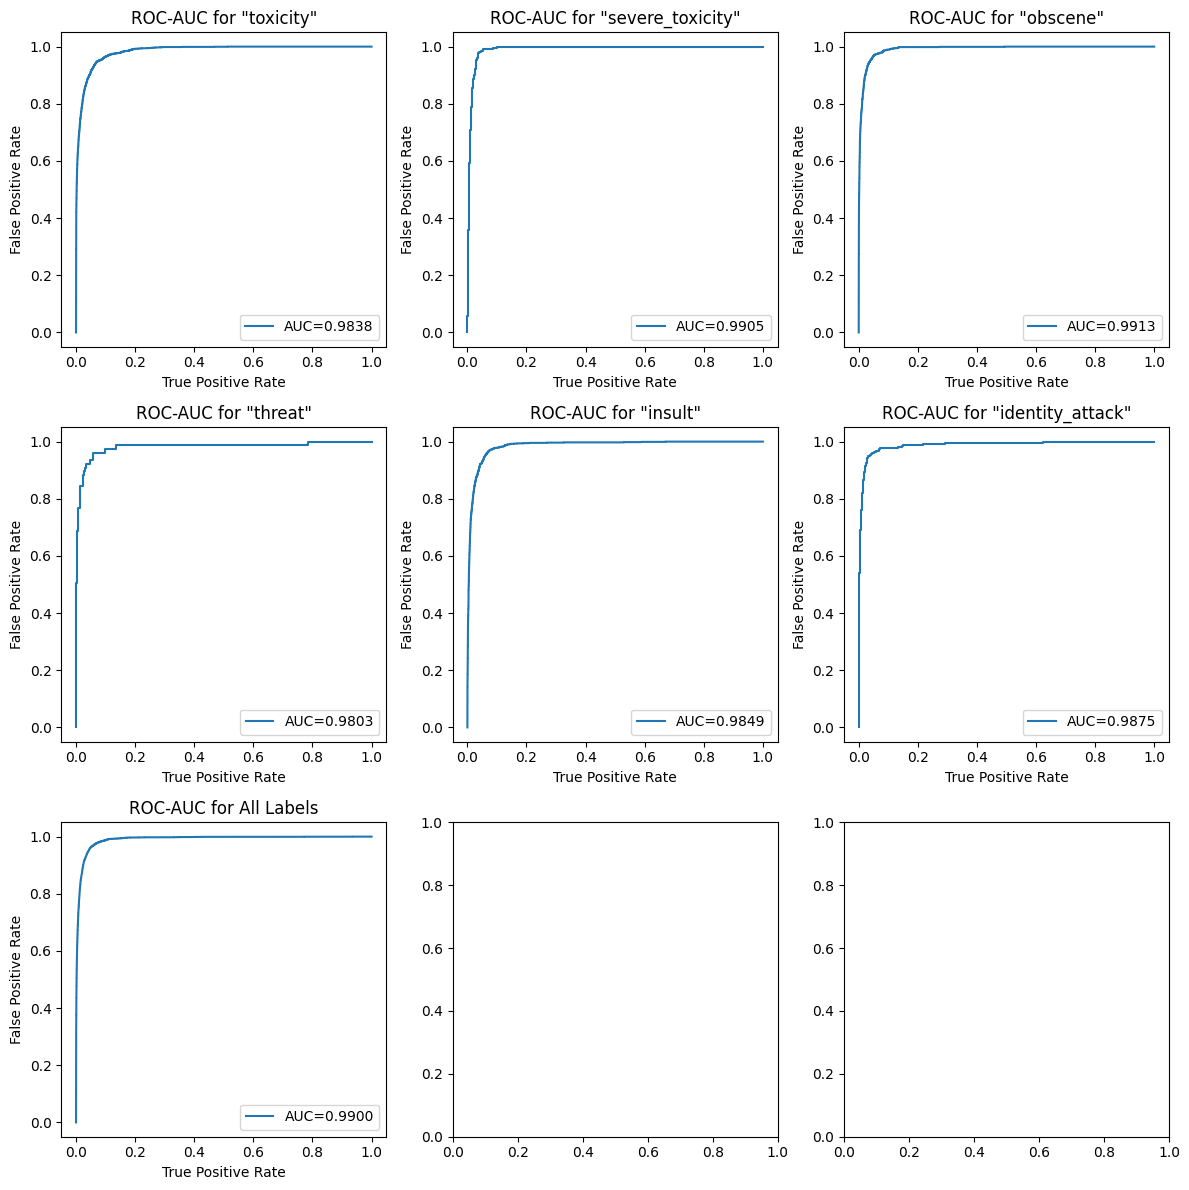

In [7]:
model_results = results['jigsaw']

targets = {}
predictions = {}
for i, label in enumerate(labels):
    targets[label] = [s['target'][i] for s in model_results['data_points']]
    predictions[label] = [s['prediction'][i] for s in model_results['data_points']]

plot_histogram(targets, predictions)
plot_roc_auc(targets, predictions)


## Secondary Positive Data

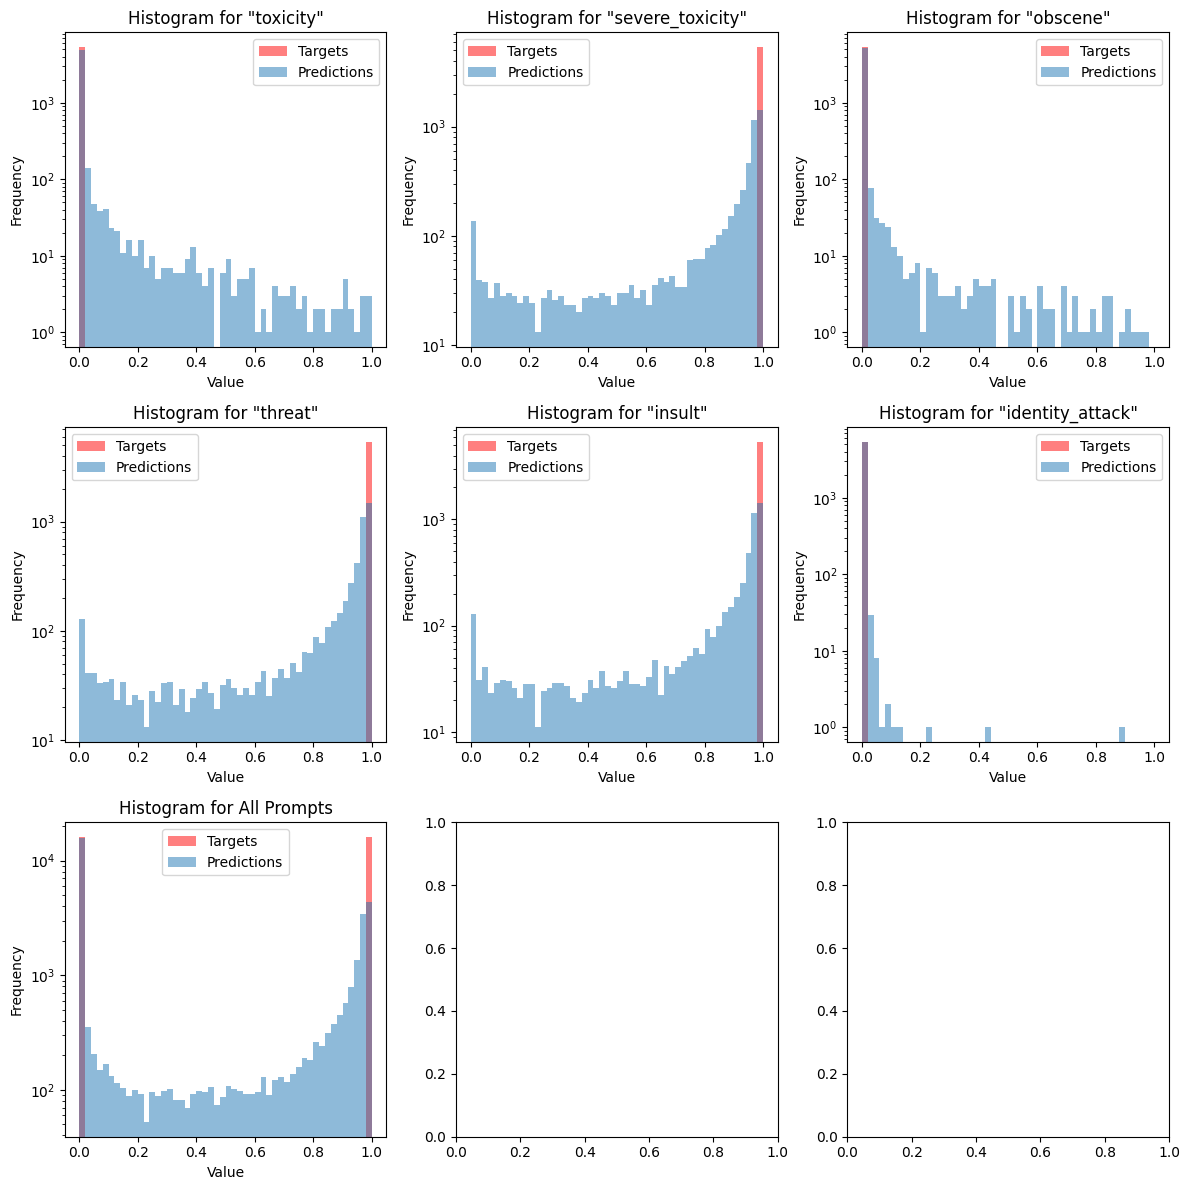

In [8]:
model_results = results['secondary_positive']

targets = {}
predictions = {}
for i, label in enumerate(labels):
    targets[label] = [s['target'][i] for s in model_results['data_points']]
    predictions[label] = [s['prediction'][i] for s in model_results['data_points']]

plot_histogram(targets, predictions)


## Secondary Neutral Data

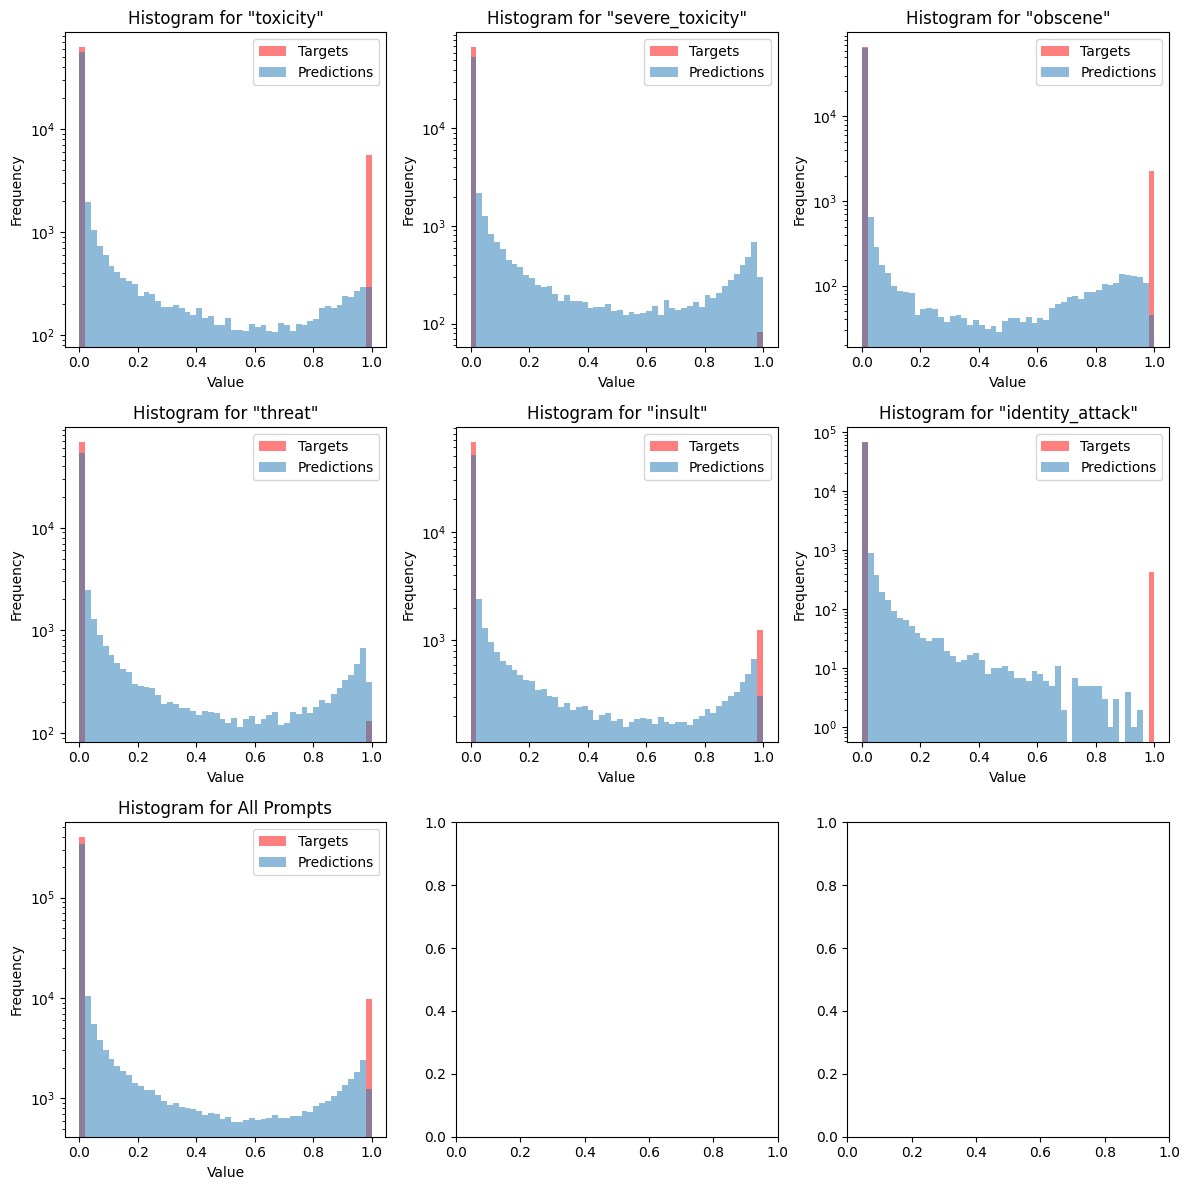

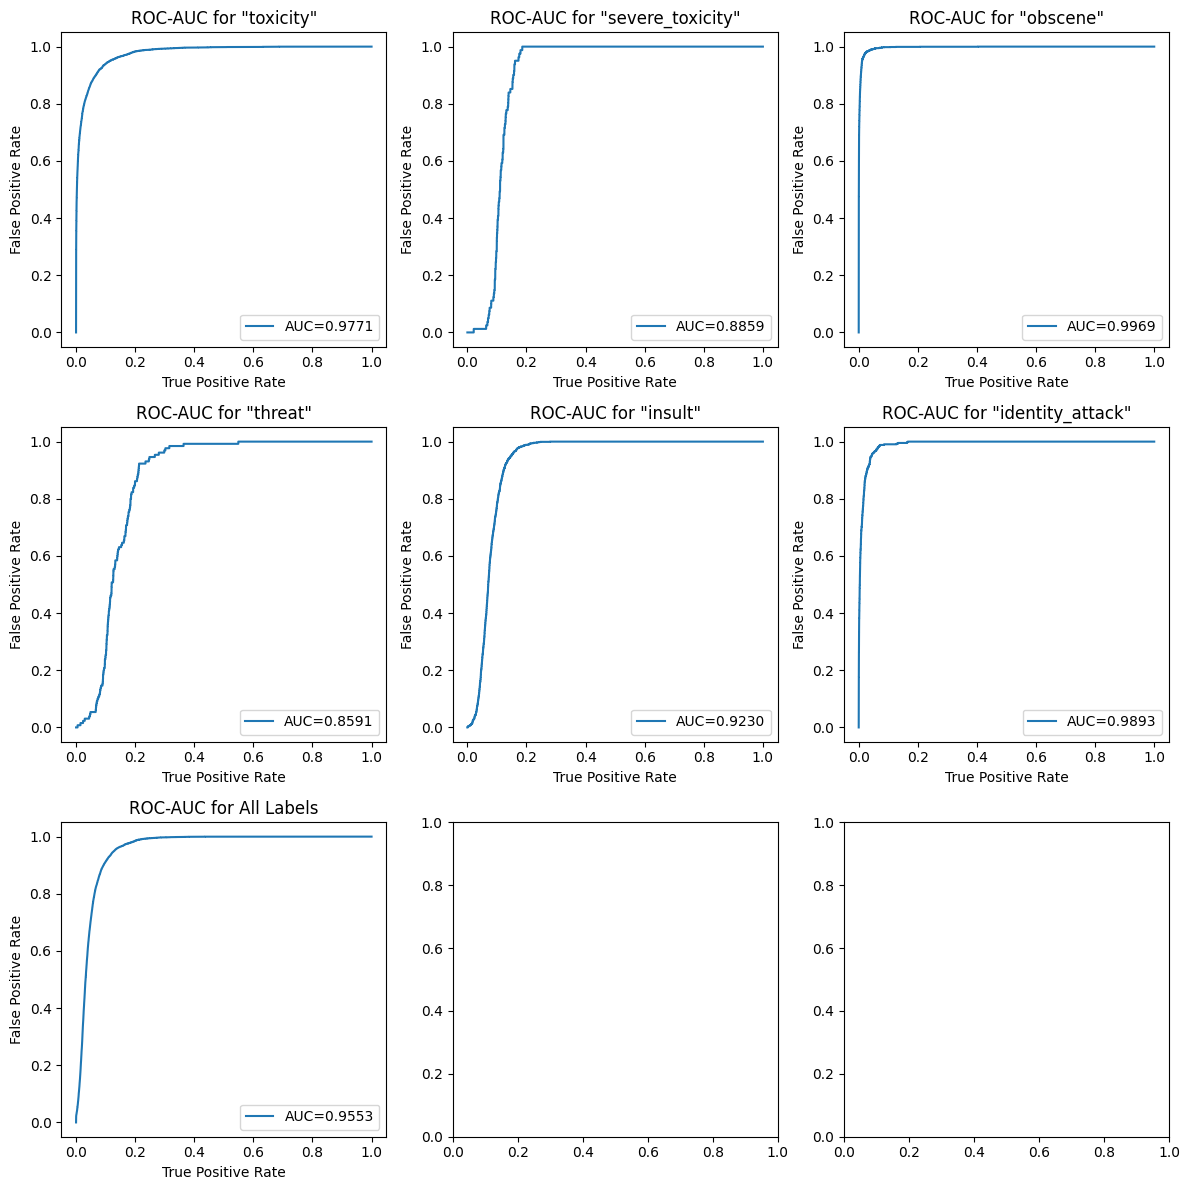

In [9]:
model_results = results['secondary_neutral']

targets = {}
predictions = {}
for i, label in enumerate(labels):
    targets[label] = [s['target'][i] for s in model_results['data_points']]
    predictions[label] = [s['prediction'][i] for s in model_results['data_points']]

plot_histogram(targets, predictions)
plot_roc_auc(targets, predictions)


## All data

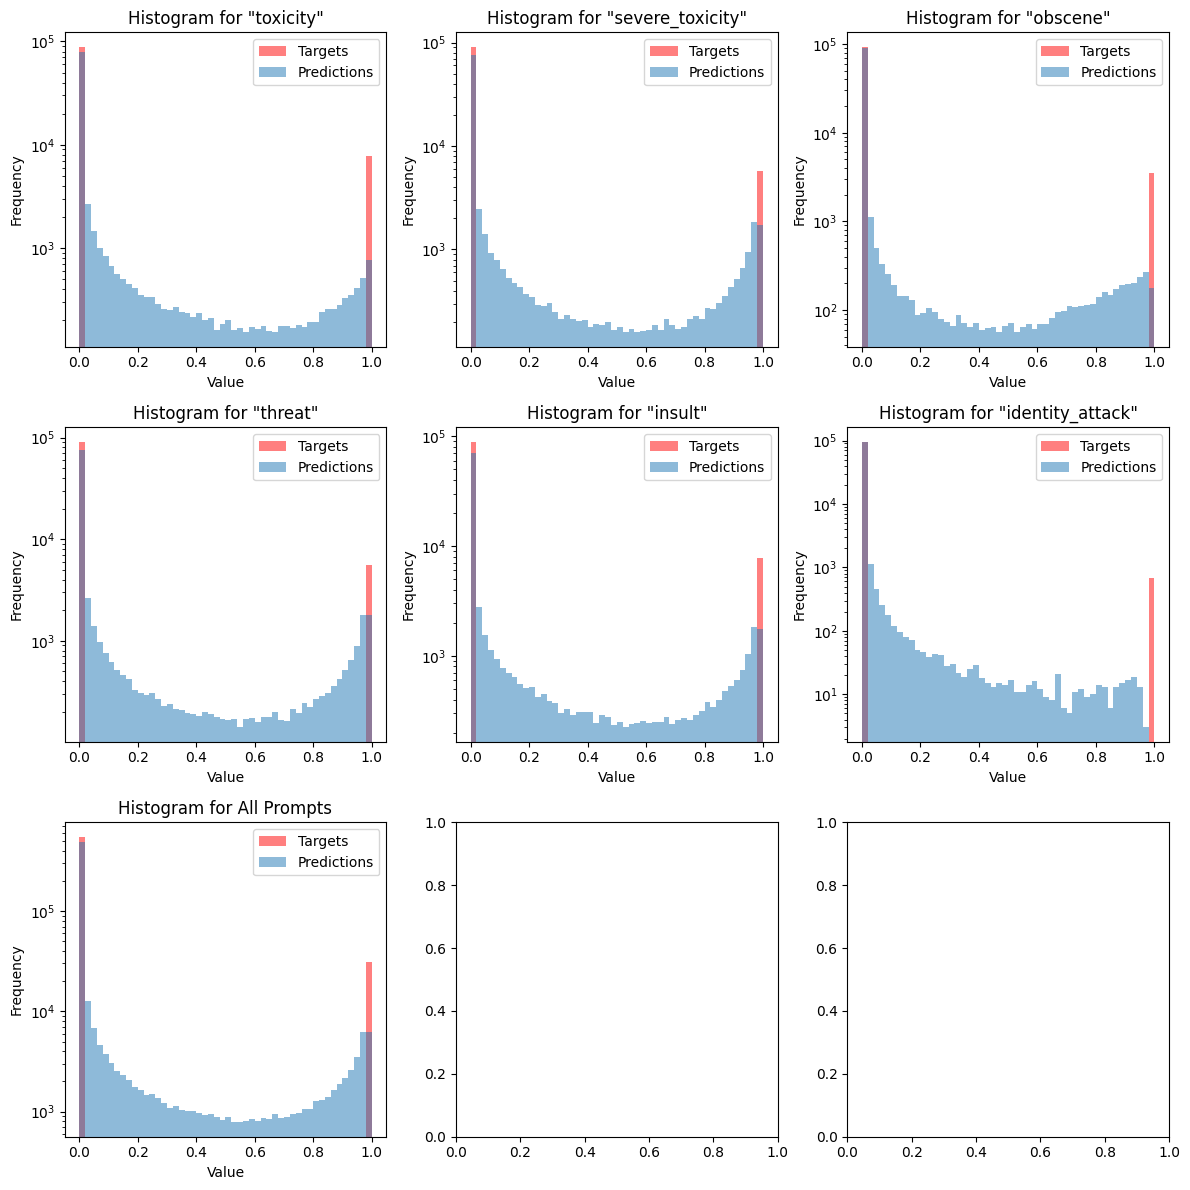

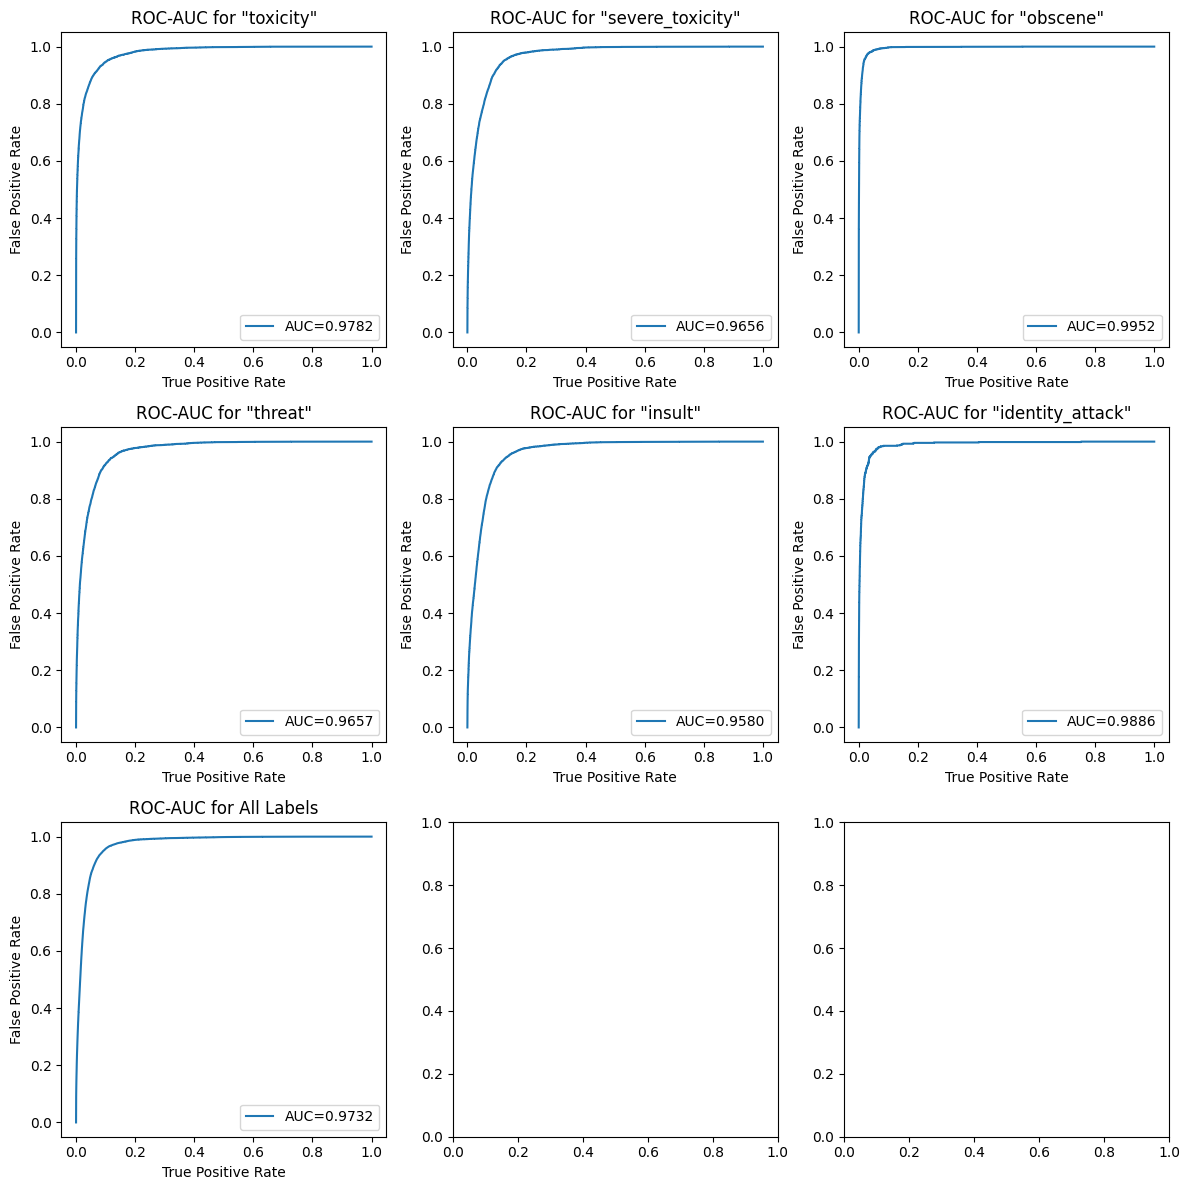

In [10]:
model_results_jigsaw = results['jigsaw']['data_points']
model_results_secondary_positive = results['secondary_positive']['data_points']
model_results_secondary_neutral = results['secondary_neutral']['data_points']

targets = {}
predictions = {}
for i, label in enumerate(labels):
    targets[label] = [s['target'][i] for s in model_results_jigsaw] + \
        [s['target'][i] for s in model_results_secondary_positive] + \
        [s['target'][i] for s in model_results_secondary_neutral]
    predictions[label] = [s['prediction'][i] for s in model_results_jigsaw] + \
        [s['prediction'][i] for s in model_results_secondary_positive] + \
        [s['prediction'][i] for s in model_results_secondary_neutral]

plot_histogram(targets, predictions)
plot_roc_auc(targets, predictions)

# Histogram across Epochs

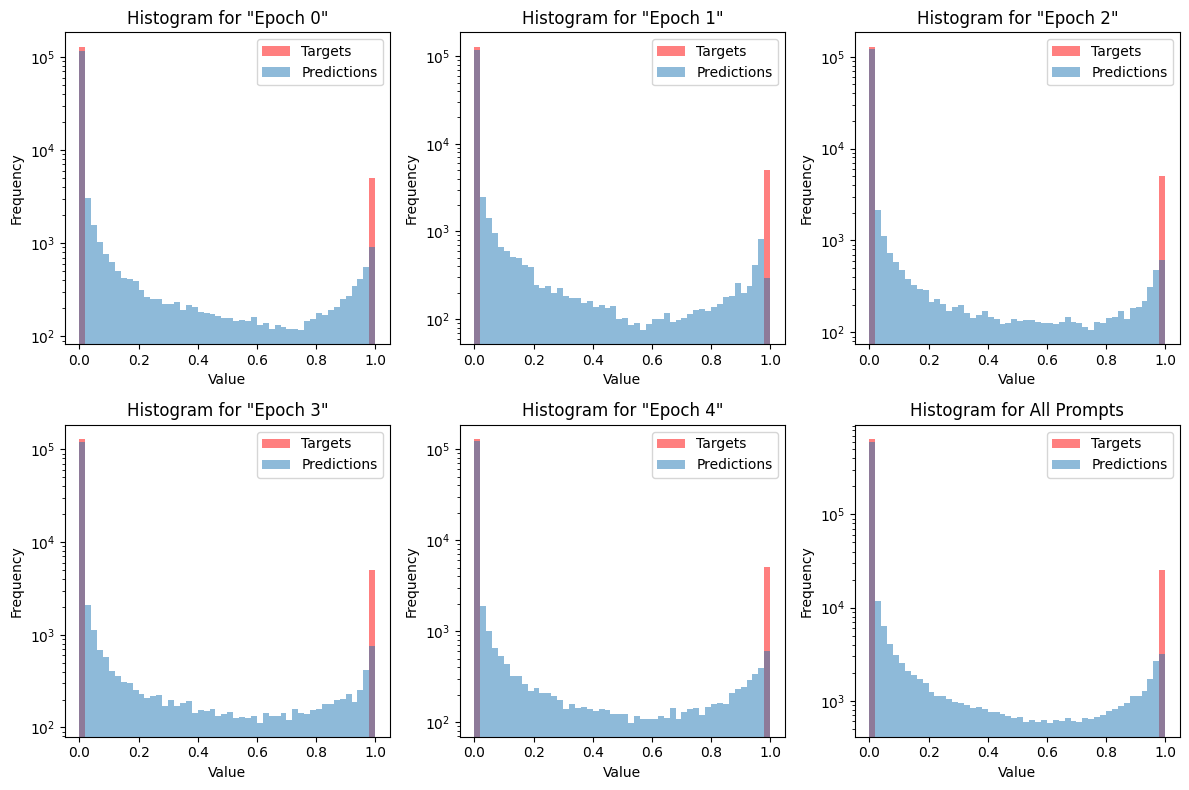

In [12]:
targets = {}
predictions = {}
for epoch, data in multi_epoch_data.items():
    nested_values = [s['target'] for s in data['jigsaw']['data_points']]
    targets[f"Epoch {epoch}"] = [item for sublist in nested_values for item in sublist]
    nested_values = [s['prediction'] for s in data['jigsaw']['data_points']]
    predictions[f"Epoch {epoch}"] = [item for sublist in nested_values for item in sublist]

plot_histogram(targets, predictions)


# Scores across Epochs

In [64]:
data_sets = ['jigsaw', 'secondary_positive', 'secondary_neutral', 'ALL']

In [ ]:
for data_name in data_sets:
    mean_scores = {}
    for epoch, all_data in multi_epoch_data.items():
        data = all_data[data_name]
        mean_scores[epoch] = {
            'f1': data['mean_f1'],
            'recall': data['mean_recall'],
            'precision': data['mean_precision']
        }

    plot_score_graph(mean_scores, x_label="Epochs", title=f"Scores per Epoch on {data_name} dataset")

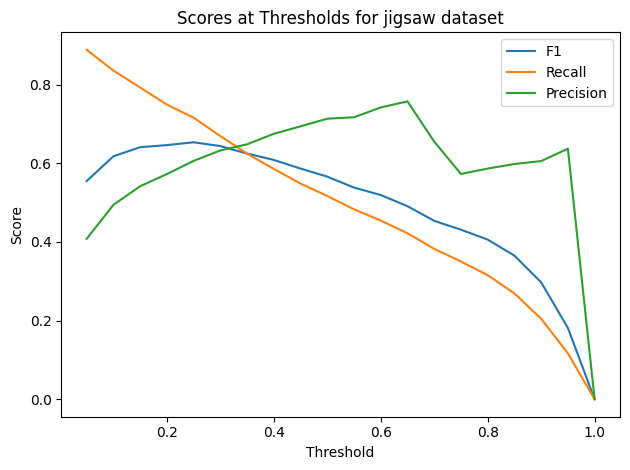

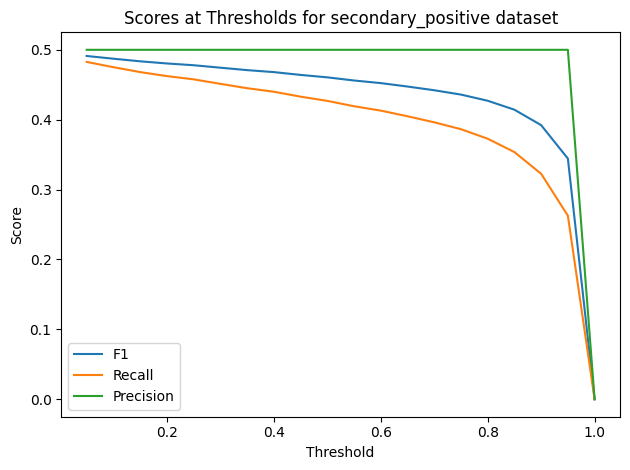

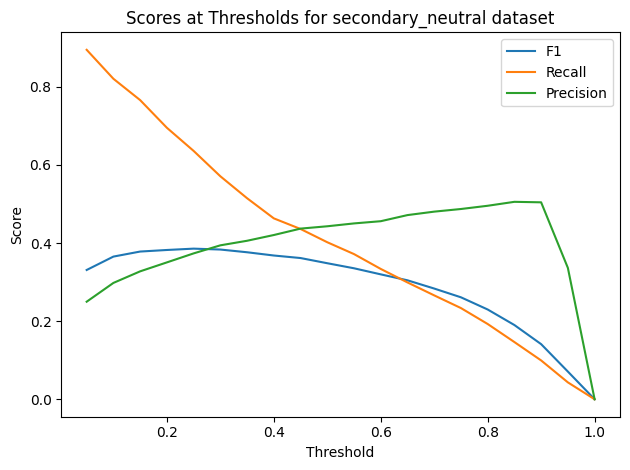

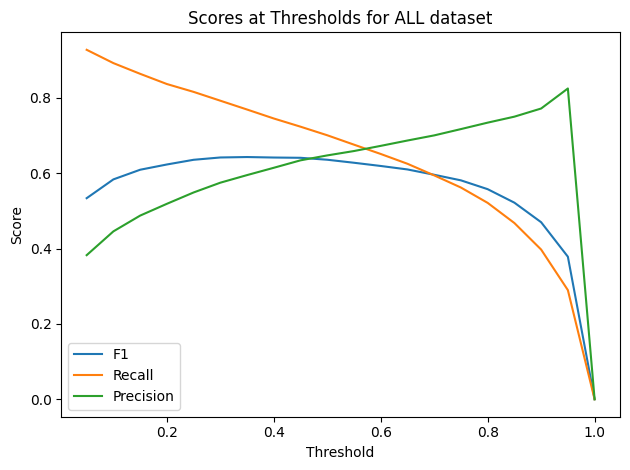

In [65]:
for data_name in data_sets:
    data = results[data_name]['threshold_scores']
    mean_scores = {}
    for threshold, all_data in data.items():
        mean_scores[round(float(threshold), 2)] = {
            'f1': all_data['mean_f1'],
            'recall': all_data['mean_recall'],
            'precision': all_data['mean_precision']
        }
    plot_score_graph(mean_scores, "Threshold", f"Scores at Thresholds for {data_name} dataset")